# Benchmarking:

In [1]:
import numpy as np
from formatData import loadData
from qml.kernels import gaussian_kernel, matern_kernel
from qml.math import cho_solve
from utils import unison_shuffle
from sklearn.model_selection import train_test_split
from gan import GenAdvNetwork
import tensorflow as tf
from utils import random_generator
from matplotlib import pyplot as plt

2023-05-13 23:49:16.058365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Comparing the performance of KRR model trained in one trajectory and testing in: 
- another trajectory

### Loading Data

In [2]:
"""
Loading data
Note than we can only specify absolute location of the raw data
"""
molRep2D, energies = loadData(12, "/home/panthibivek/thesis/GAN_pkg/data/traj.xyz")
X_train, X_test, y_train, y_test = train_test_split(molRep2D,energies,
                                   test_size=0.1)

print("Training data size:", X_train.shape)
print("Test data size:", X_test.shape)

input data size: (10000, 78)
output data size: (10000,)
Training data size: (9000, 78)
Test data size: (1000, 78)


### Regression using parameters from Baseline Experiment

In [3]:
"""
Regression
"""
def regression(X : np.array, Y : np.array, sigma : float, lambda_ : float):
    K = matern_kernel(X, X, sigma, order=0, metric='l2')
    K[np.diag_indices_from(K)] += lambda_
    alpha = cho_solve(K, Y)
    return alpha

"""
Prediction
"""
def prediction(X : np.array, arr_to_predict : np.array, sigma : float, alpha_ : np.array):
    Ks = matern_kernel(arr_to_predict, X, sigma, order=0, metric='l2')
    return np.dot(Ks, alpha_)

In [4]:
sigma = 200.0
lambda_ = 1e-8
temp_alpha = regression(X_train, y_train, sigma, lambda_)
prediction_arr = prediction(X_train, X_test, sigma, temp_alpha)
mean_abs_errors = np.mean(np.abs(prediction_arr - y_test))
print("Mean Absolute Error : {}".format(mean_abs_errors))

Mean Absolute Error : 0.00025233992229309267


### Loading new Trajectories Dataset

In [4]:
energies_arr = []
energyFilename = "/home/panthibivek/thesis/GAN_pkg/data/MD/traj1_energies.txt"
with open("/home/panthibivek/thesis/GAN_pkg/data/MD/properties/trajectory1/es_energies/ZINDO_verytight.dat", 'r') as f:
    for line in f:
        if line:
            lst = line.strip().split('\t')
            energies_arr.append(float(lst[-1]))
energies_arr = np.array(energies_arr)
np.savetxt(fname=energyFilename, X=energies_arr, delimiter='\n')

In [5]:
"""
Loading data
Note than we can only specify absolute location of the raw data
"""
newTrajMolRep, newTrajEnergies = loadData(max_size=12, 
                                filename="/home/panthibivek/thesis/GAN_pkg/data/MD/trajectory1.xyz", 
                                energyFilename=energyFilename,
                                xyzdirname="/data/Traj1/AllMolecules",
                                coulombMtxFilename="/data/Traj1/lower_coulomb_mtx_array.txt")

input data size: (10001, 78)
output data size: (10001,)


In [7]:
prediction_arr = prediction(X_train, newTrajMolRep, sigma, temp_alpha)
mean_abs_errors = np.mean(np.abs(prediction_arr - newTrajEnergies))
print("Mean Absolute Error : {}".format(mean_abs_errors))

Mean Absolute Error : 0.8173697280201754


#### Comparing the performance of KRR model trained in one trajectory and samples from GAN model and testing in:
- same trajectory samples

In [6]:
"""
Loading data
Note than we can only specify absolute location of the raw data
"""
ganTrajMolRep, ganTrajEnergies = loadData(max_size=12, 
                                filename="demo_name.xyz", 
                                energyFilename="/home/panthibivek/thesis/GAN_pkg/config_files_orca/calculated_energies.txt",
                                xyzdirname="/config_files_orca/newMappedMolecules",
                                coulombMtxFilename="/config_files_orca/gan_lower_coulomb_mtx_array.txt")
ganTrajEnergies = ganTrajEnergies * 27.2114079527

input data size: (10000, 78)
output data size: (10000,)


In [22]:
sigma = 200.0
lambda_ = 1e-8
new_X_train = np.concatenate((X_train, ganTrajMolRep), axis=0)
new_Y_train = np.concatenate((y_train, ganTrajEnergies))

In [10]:
# indices = np.arange(new_X_train.shape[0])
# np.random.shuffle(indices)

# new_X_train = new_X_train[indices]
# new_Y_train = new_Y_train[indices]

temp_alpha = regression(new_X_train, new_Y_train, sigma, lambda_)
prediction_arr = prediction(new_X_train, X_test, sigma, temp_alpha)
mean_abs_errors = np.mean(np.abs(prediction_arr - y_test))
print("Mean Absolute Error : {}".format(mean_abs_errors))

Mean Absolute Error : 0.0002714226045434032


In [11]:
training_sample_sizes = [500] + [int(i) for i in range(1000, 19000, 2000)]
lambda_ = 1e-8
mean_abs_errors_list = []
for sample_size in training_sample_sizes:
    temp_alpha = regression(new_X_train[:sample_size], new_Y_train[:sample_size], sigma, lambda_)
    Y_predicted = prediction(new_X_train[:sample_size], X_test, sigma, temp_alpha)
    mean_abs_e = np.mean(np.abs(Y_predicted - y_test))
    mean_abs_errors_list.append(mean_abs_e)

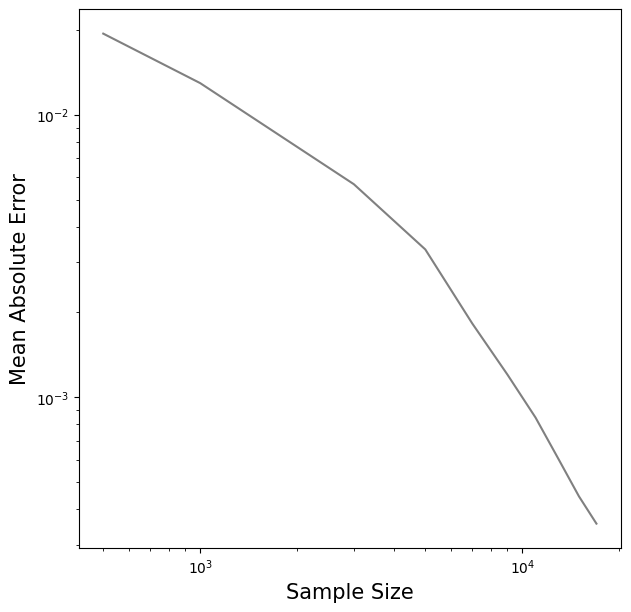

In [12]:
plt.figure(figsize=(7,7))
plt.plot(training_sample_sizes, mean_abs_errors_list, c="gray")
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.yscale('log')
plt.xscale('log')
fig2 = plt.gcf()
plt.show()
fig2.savefig('sample_vs_MAE_gan_sampling.png', dpi = 300)

#### Comparing the performance of KRR model trained in one trajectory and samples from GAN model and testing in:
- different trajectory samples

In [13]:
alpha_ = regression(new_X_train, new_Y_train, sigma, lambda_)
prediction_arr = prediction(new_X_train, newTrajMolRep, sigma, alpha_)
mean_abs_errors = np.mean(np.abs(prediction_arr - newTrajEnergies))
print("Mean Absolute Error : {}".format(mean_abs_errors))

Mean Absolute Error : 0.7829671234311615


In [8]:
training_sample_sizes = [500] + [int(i) for i in range(1000, 19000, 2000)]
sigma = 200.0
lambda_ = 1e-8
mean_abs_errors_list = []
for sample_size in training_sample_sizes:
    temp_alpha = regression(new_X_train[:sample_size], new_Y_train[:sample_size], sigma, lambda_)
    Y_predicted = prediction(new_X_train[:sample_size], newTrajMolRep[9000:], sigma, temp_alpha)
    mean_abs_e = np.mean(np.abs(Y_predicted - newTrajEnergies[9000:]))
    mean_abs_errors_list.append(mean_abs_e)

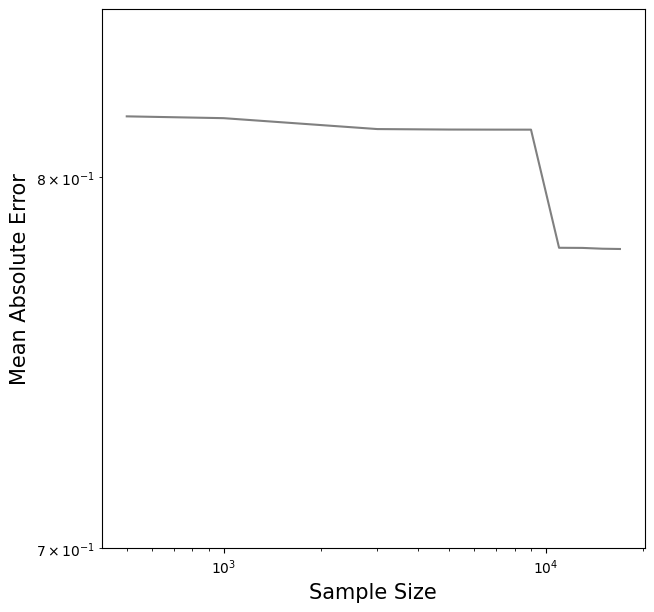

In [17]:
plt.figure(figsize=(7,7))
plt.plot(training_sample_sizes, mean_abs_errors_list, c="gray")
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.7, 0.85)
fig2 = plt.gcf()
plt.show()
fig2.savefig('traj1_vs_MAE_gan_sampling.png', dpi = 300)

In [10]:
energies_arr = []
energyFilename = "/home/panthibivek/thesis/GAN_pkg/data/MD/traj2_energies.txt"
with open("/home/panthibivek/thesis/GAN_pkg/data/MD/properties/trajectory2/es_energies/ZINDO_verytight.dat", 'r') as f:
    for line in f:
        if line:
            lst = line.strip().split('\t')
            energies_arr.append(float(lst[-1]))
energies_arr = np.array(energies_arr)
np.savetxt(fname=energyFilename, X=energies_arr, delimiter='\n')

In [11]:
"""
Loading data
Note than we can only specify absolute location of the raw data
"""
newTraj2MolRep, newTraj2Energies = loadData(max_size=12, 
                                filename="/home/panthibivek/thesis/GAN_pkg/data/MD/trajectory2.xyz", 
                                energyFilename=energyFilename,
                                xyzdirname="/data/Traj2/AllMolecules",
                                coulombMtxFilename="/data/Traj2/lower_coulomb_mtx_array.txt")

input data size: (10001, 78)
output data size: (10001,)


In [18]:
prediction_arr_ = prediction(new_X_train[:20000], newTraj2MolRep, sigma, alpha_)
mean_abs_error_ = np.mean(np.abs(prediction_arr_ - newTraj2Energies))
print("Mean Absolute Error : {}".format(mean_abs_error_))

Mean Absolute Error : 0.7783388354916239


In [12]:
training_sample_sizes = [500] + [int(i) for i in range(1000, 19000, 2000)]
sigma = 200.0
lambda_ = 1e-8
mean_abs_errors_list2 = []
for sample_size in training_sample_sizes:
    temp_alpha = regression(new_X_train[:sample_size], new_Y_train[:sample_size], sigma, lambda_)
    Y_predicted = prediction(new_X_train[:sample_size], newTraj2MolRep[9000:], sigma, temp_alpha)
    mean_abs_e = np.mean(np.abs(Y_predicted - newTraj2Energies[9000:]))
    mean_abs_errors_list2.append(mean_abs_e)

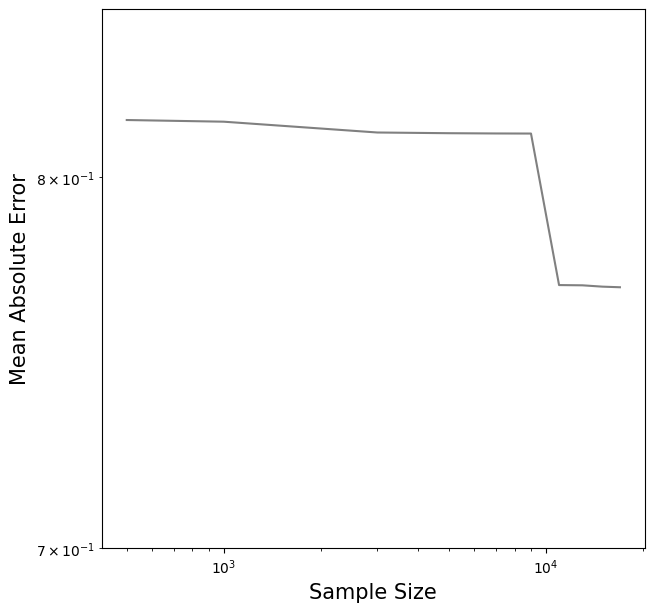

In [16]:
plt.figure(figsize=(7,7))
plt.plot(training_sample_sizes, mean_abs_errors_list2, c="gray")
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.7, 0.85)
fig2 = plt.gcf()
plt.show()
fig2.savefig('traj2_vs_MAE_gan_samples.png', dpi = 300)

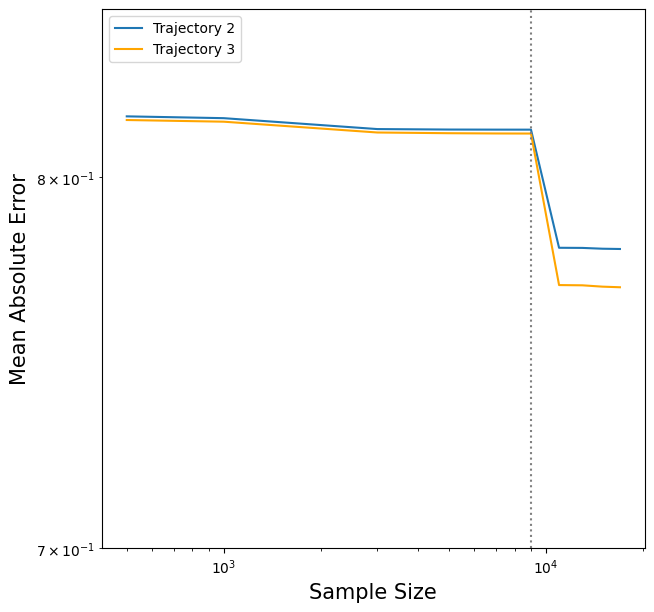

In [23]:
plt.figure(figsize=(7,7))
plt.plot(training_sample_sizes, mean_abs_errors_list, label="Trajectory 2")
plt.plot(training_sample_sizes, mean_abs_errors_list2, c="orange", label="Trajectory 3")
plt.xlabel('Sample Size', fontsize=15)
plt.ylabel('Mean Absolute Error', fontsize=15)
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.7, 0.85)
plt.legend()
plt.axvline(x=9000, c="gray", linestyle="dotted")
fig2 = plt.gcf()
plt.show()
fig2.savefig('traj1and2_vs_MAE_gan_samples.png', dpi=300)
